In [50]:
using PyPlot

##### Plot functions

In [51]:
function draw_arrow(i::Int64, j::Int64, action::Symbol, dim::(Int64, Int64))
    NX = dim[1]
    NY = dim[2]+1
    offset = 0.1
    if action == :north
        plot([i-1+offset, i-0.5, i-offset, i-1+offset], [NY-j-1+offset, NY-j-offset, NY-j-1+offset, NY-j-1+offset], color="blue", lw=2)
    elseif action == :south
        plot([i-1+offset, i-0.5, i-offset, i-1+offset], [NY-j-offset, NY-j-1+offset, NY-j-offset, NY-j-offset], color="blue", lw=2)
    elseif action == :east
        plot([i-1+offset, i-1+offset, i-offset, i-1+offset], [NY-j-offset, NY-j-1+offset, NY-j-0.5, NY-j-offset], color="blue", lw=2)
    elseif action == :west
        plot([i-offset, i-offset, i-1+offset, i-offset], [NY-j-offset, NY-j-1+offset, NY-j-0.5, NY-j-offset], color="blue", lw=2)
    end
end

function plot_data(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    s = (size(V)[1]*1.1, size(V)[2] .* 0.5)
    figure(figsize=s)
    subplot(121)
    xticks([])
    yticks([])
    xlim([2,size(V)[1]]-1)
    ylim([2,size(V)[2]]-1)

    for i = 1:size(V)[1]-2
        plot([i,i],[0,size(V)[2]], color="black")
    end
    for i = 1:size(V)[2]-2
        plot([0,size(V)[1]], [i,i], color="black")
    end
    
    for i = 2:size(V)[1]-1
        for j = 2:size(V)[2]-1
            draw_arrow(j, i, policy[i, j], size(V))
            #draw_arrow(j, i, :west, size(V))
        end
    end
    subplot(122)
    colorbar(imshow(V[2:end-1,2:end-1], interpolation="none"))
    xticks([])
    yticks([])
    c_values = [v>-100?v:0 for v in V]
    clim([maximum(c_values),minimum(c_values)])
end

plot_data (generic function with 1 method)

##### Convert definition to maze representation

In [52]:
function convert_string_to_string_array(s::String)
    index = 1
    while s[index] == ' ' || s[index] == '\n'
        index = index + 1
    end
    maze = nothing
    row = []
    for i=index:length(s)
        if s[i] == '\n'
            if maze == nothing
                maze = row
            else
                maze = hcat(maze, row)
            end
            row = []
        else
            row = [row, s[i]]
        end
    end
    return maze'
end



function create_experiment_setup(definition::String)
    actions = [:north, :east, :south, :west, :none]

    maze   = convert_string_to_string_array(maze_definition)
    V      = zeros(size(maze))
    policy = reshape([actions[int64(ceil(rand() * (length(actions)-1)))] for i = 1:length(maze)], size(maze))

    for i=1:length(maze)
        if maze[i] in ['#', 'T']
            V[i] = state_reward_function[maze[i]]
            policy[i] = :none
        end
    end

    return maze, policy, V
end

create_experiment_setup (generic function with 1 method)

# Policy iteration

In [53]:
function policy_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    for i = 2:size(maze)[1]-1
        for j = 2:size(maze)[2]-1
            if maze[i,j] == ' '
                possible_actions = []
                action_values = []
                if maze[i-1,j] != '#'
                    possible_actions = [possible_actions, :north]
                    action_values    = [action_values, V[i-1, j]]
                end
                if maze[i+1,j] != '#'
                    possible_actions = [possible_actions, :south]
                    action_values    = [action_values, V[i+1, j]]
                end

                if maze[i,j-1] != '#'
                    possible_actions = [possible_actions, :west]
                    action_values    = [action_values, V[i, j-1]]
                end
                if maze[i,j+1] != '#'
                    possible_actions = [possible_actions, :east]
                    action_values    = [action_values, V[i, j+1]]
                end
                best_action_value = maximum(action_values)
                possible_actions = possible_actions[findin(action_values,best_action_value)]
                action = possible_actions[int(ceil(rand() * length(possible_actions)))]
                policy[i,j] = action
            end
        end
    end
end

policy_iteration! (generic function with 1 method)

# Policy evaluation

In [54]:
function policy_evaluation!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    new_values = copy(V)
    last_values = copy(V)
    delta = 100.0
    index = 0
    while delta > 0.01 && index < 5000
        index = index + 1
        for i = 2:size(last_values)[1] - 1
            for j = 2:size(last_values)[2] - 1
                if policy[i,j] == :north
                    new_values[i,j] = last_values[i-1,j] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :south
                    new_values[i,j] = last_values[i+1,j] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :east
                    new_values[i,j] = last_values[i,j+1] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :west
                    new_values[i,j] = last_values[i,j-1] - 1.0 # -1.0 for transition
                else
                    new_values[i,j] = last_values[i,j] # terminal states
                end
            end
        end
        delta = maximum(abs(new_values[2:end-1,2:end-1] .- last_values[2:end-1,2:end-1]))
        avg   = mean((new_values[2:end-1, 2:end-1] .- last_values[2:end-1,2:end-1])^2)
        last_values = copy(new_values)
    end
    for i=2:size(V)[1] - 1
        for j=2:size(V)[2] - 1
            V[i,j] = new_values[i,j]
        end
    end
    println("Number of iterations: $index")
end

policy_evaluation! (generic function with 1 method)

### Experiment

#### Initialisation & Policy iteration 1

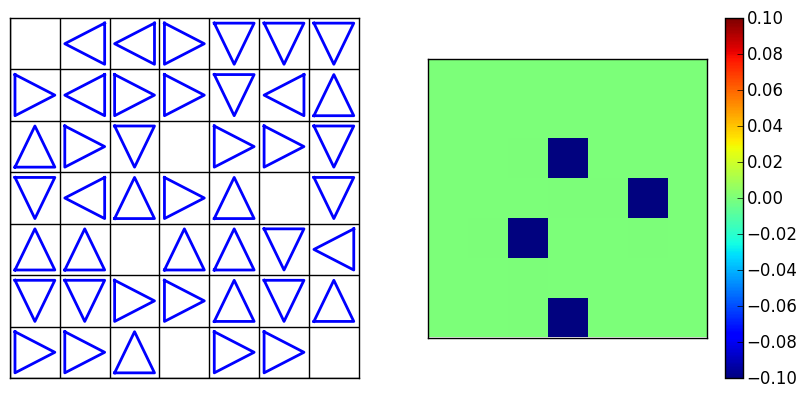

In [55]:
maze_definition = "
#########
#T      #
#       #
#   #   #
#     # #
#  #    #
#       #
#   #  T#
#########
"


state_reward_function = ['T' => 0.0, '#' => -100];


maze, policy, V = create_experiment_setup(maze_definition);

policy_iteration!(maze, policy, V)
plot_data(maze, policy, V)

#### Policy <i><u> evaluation </u></i> 1

Number of iterations: 5000


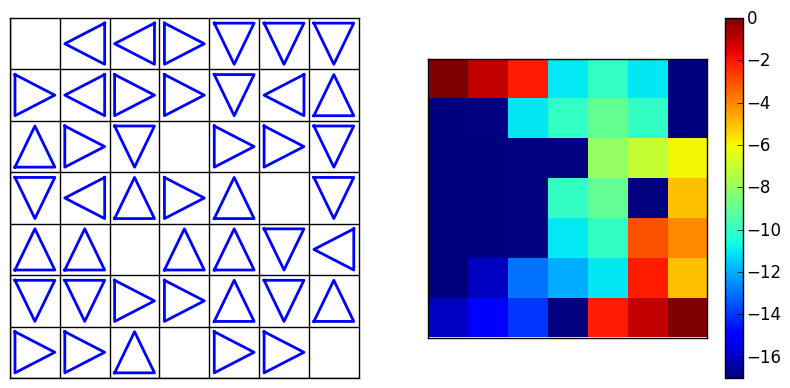

In [56]:
policy_evaluation!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> iteration </u></i> 2

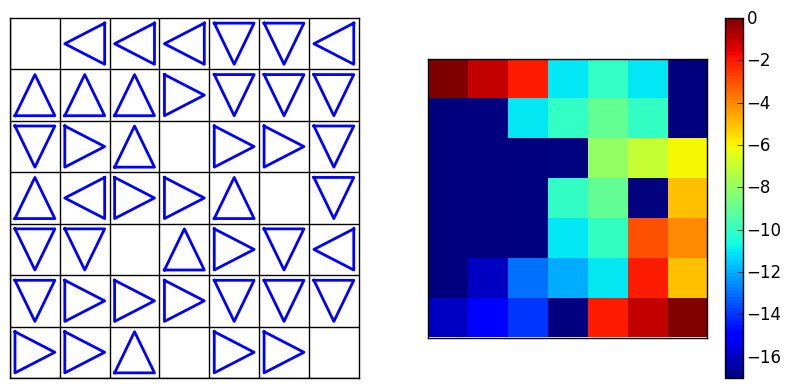

In [57]:
policy_iteration!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> evaluation </u></i> 2

Number of iterations: 5000


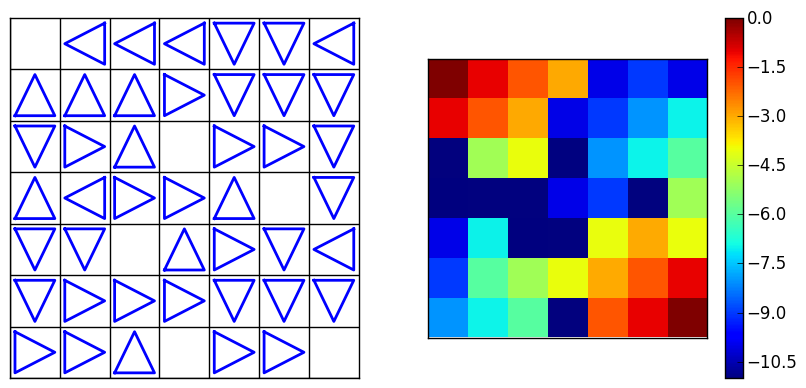

In [58]:
policy_evaluation!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> iteration </u></i> 3

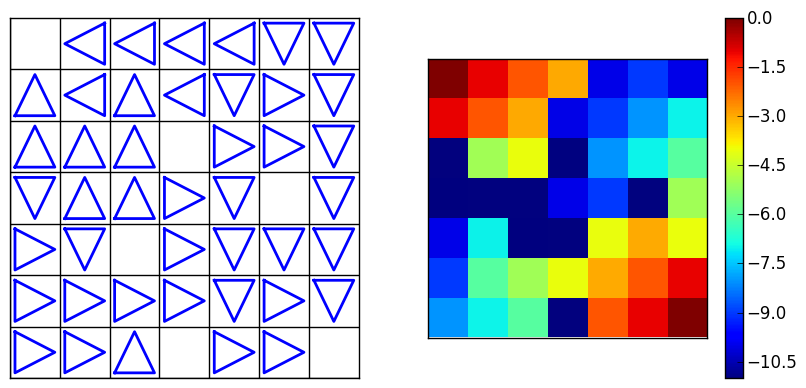

In [59]:
policy_iteration!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> evaluation </u></i> 3

Number of iterations: 7


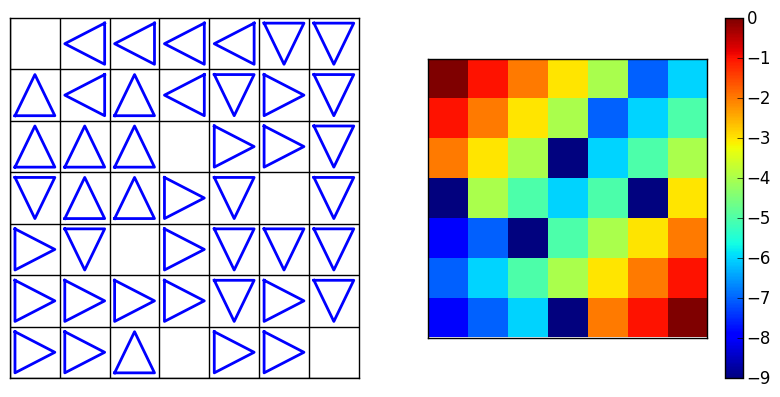

In [60]:
policy_evaluation!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> iteration </u></i> 4

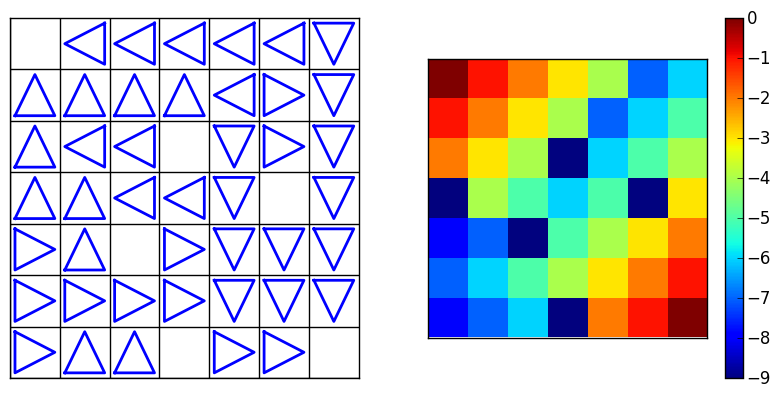

In [61]:
policy_iteration!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> evaluation </u></i> 4

Number of iterations: 3


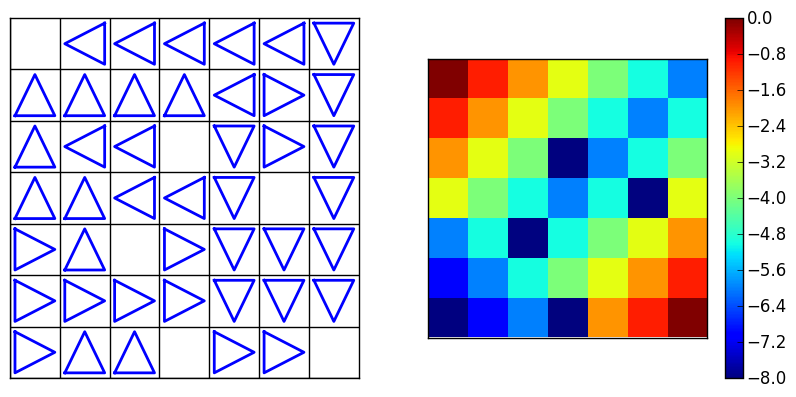

In [62]:
policy_evaluation!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> iteration </u></i> 5

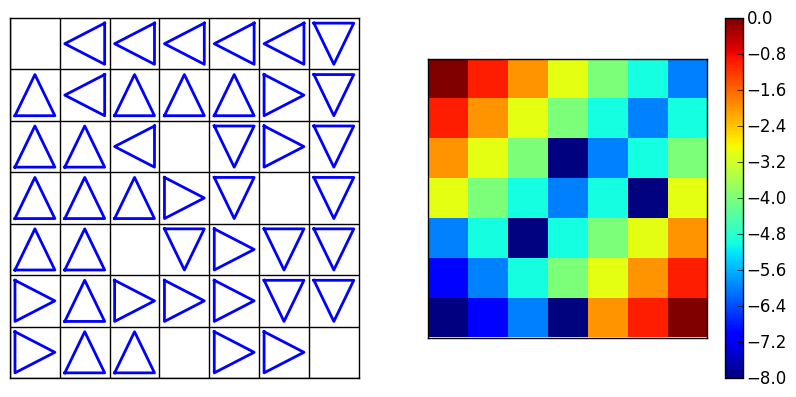

In [63]:
policy_iteration!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy <i><u> evaluation </u></i> 5

Number of iterations: 2


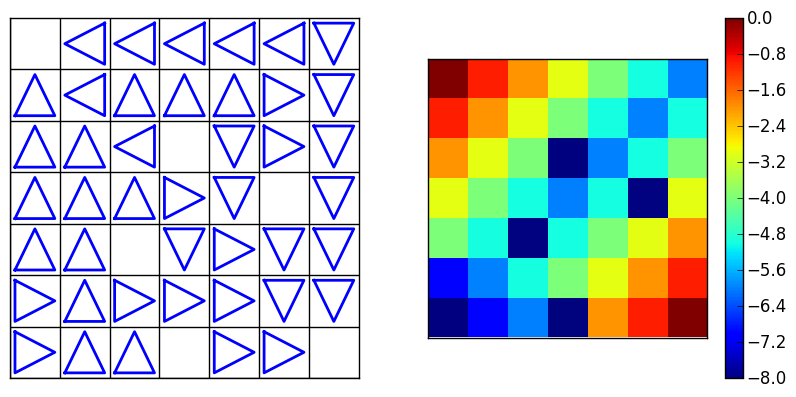

In [64]:
policy_evaluation!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy iteration 6

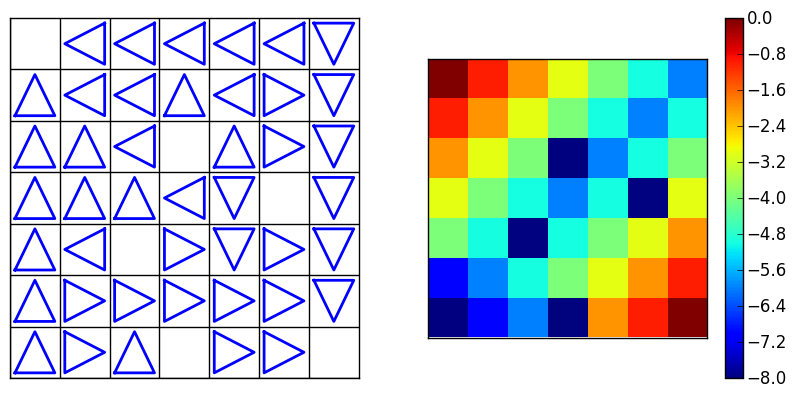

In [65]:
policy_iteration!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

#### Policy evalution 6

Number of iterations: 3


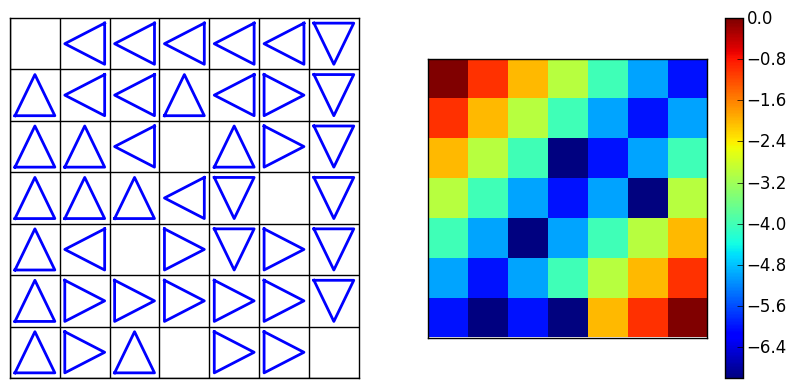

In [66]:
policy_evaluation!(maze, policy, V)
plot_data(maze, policy, V)
#println(V)
#println(policy)

# Value iteration

In [67]:
function value_iteration!(maze::Matrix{Char}, policy::Matrix{Symbol}, V::Matrix{Float64})
    new_values = copy(V)
    for i = 2:size(V)[1] - 1
        for j = 2:size(V)[2] - 1
            if policy[i,j] == :north
                new_values[i,j] = V[i-1,j] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :south
                new_values[i,j] = V[i+1,j] - 1.0 # -1.0 for transition
                elseif policy[i,j] == :east
                new_values[i,j] = V[i,j+1] - 1.0 # -1.0 for transition
            elseif policy[i,j] == :west
                new_values[i,j] = V[i,j-1] - 1.0 # -1.0 for transition
            else
                new_values[i,j] = V[i,j] # terminal states
            end
        end
    end
    for i=2:size(V)[1] - 1
        for j=2:size(V)[2] - 1
            V[i,j] = new_values[i,j]
        end
    end
    policy_iteration!(maze, policy, V)
end

value_iteration! (generic function with 1 method)

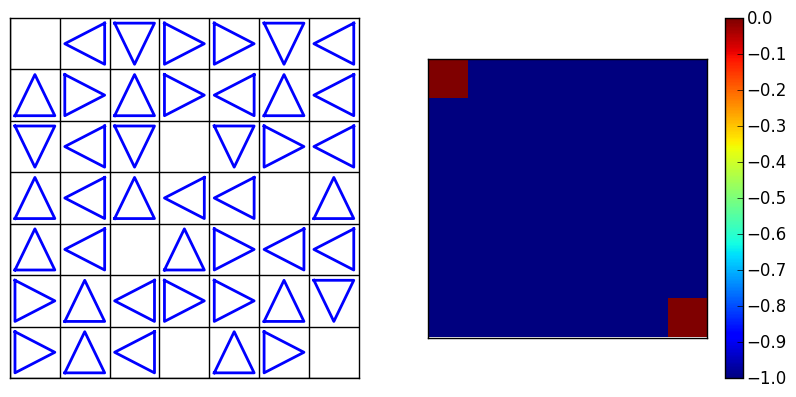

In [68]:
maze_definition = "
#########
#T      #
#       #
#   #   #
#     # #
#  #    #
#       #
#   #  T#
#########
"


state_reward_function = ['T' => 0.0, '#' => -100]

maze_definition = "
#########
#T      #
#       #
#   #   #
#     # #
#  #    #
#       #
#   #  T#
#########
"


state_reward_function = ['T' => 0.0, '#' => -100];


maze, policy, V = create_experiment_setup(maze_definition);

value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

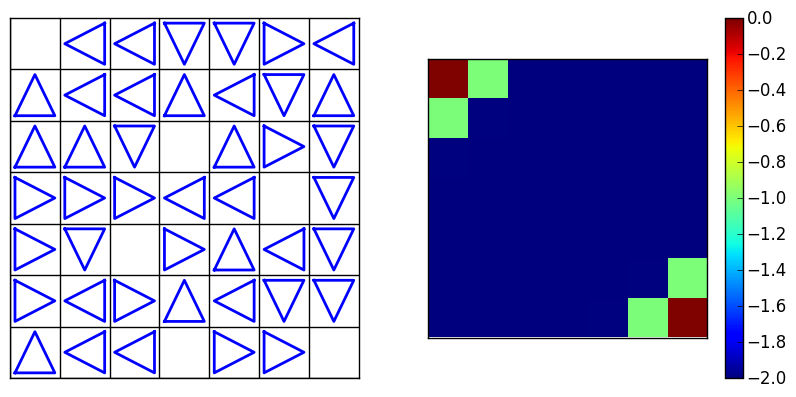

In [69]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

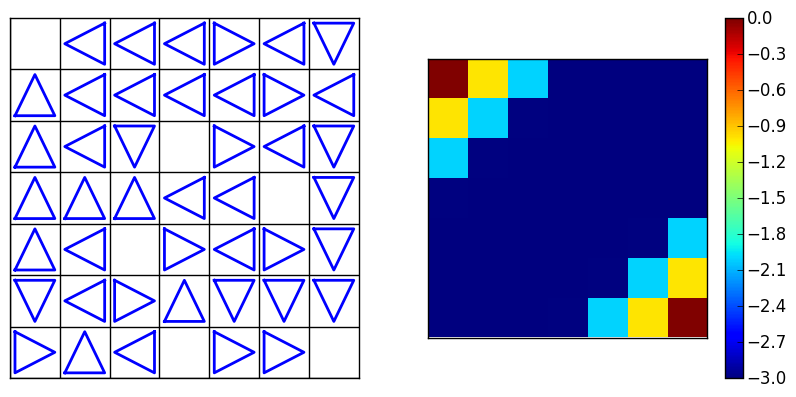

In [70]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

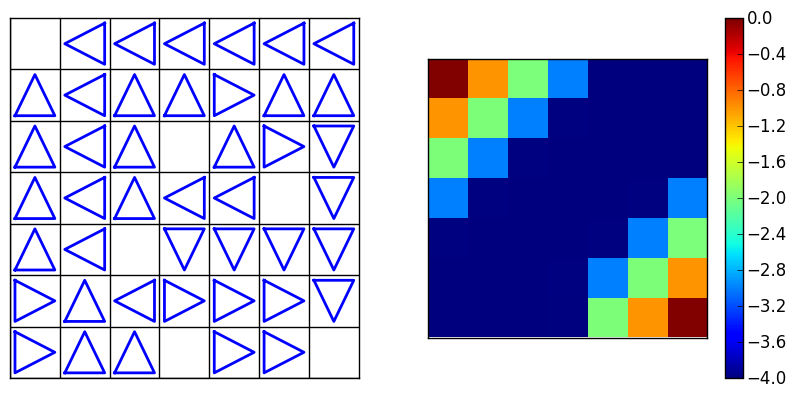

In [71]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

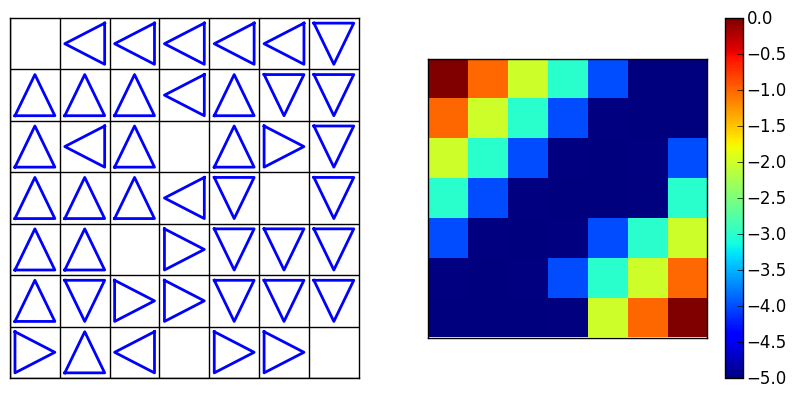

In [72]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

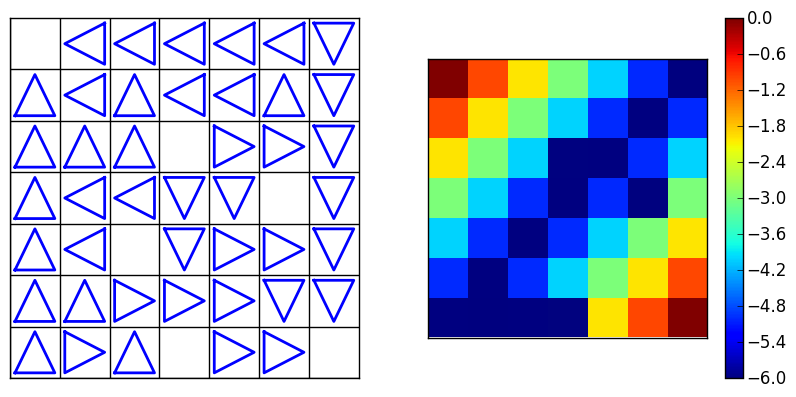

In [73]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

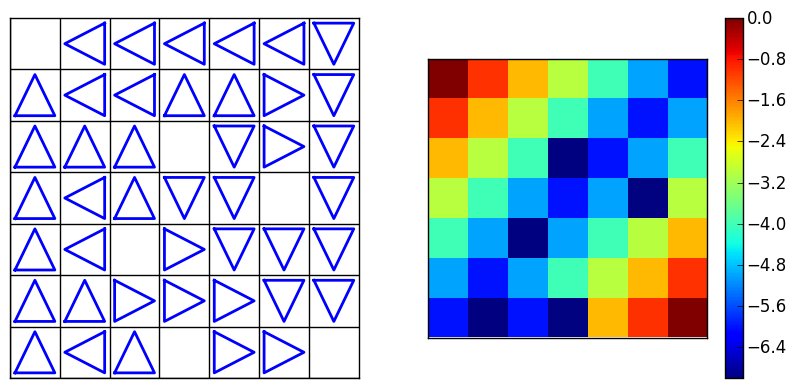

In [74]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

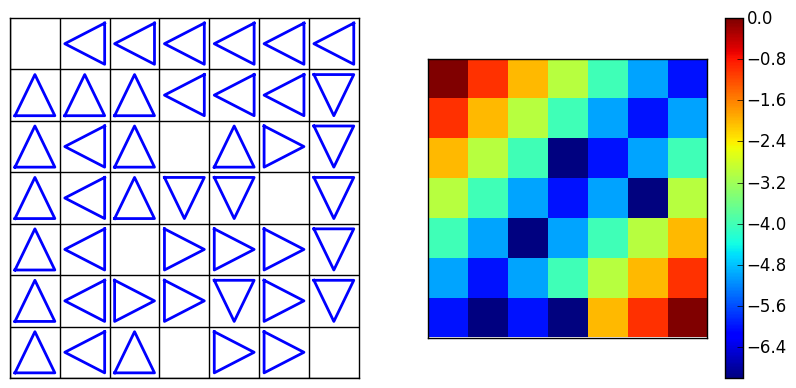

In [75]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)

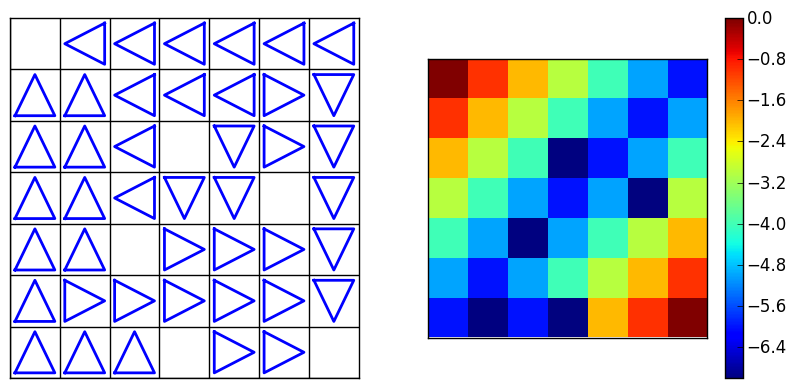

In [76]:
value_iteration!(maze, policy, V)
plot_data(maze, policy, V)